## Zadanie 1

Funkcja MSE czyli błąd średniokwadratowy. Wyznaczenie wartości kosztu w tym przypadku odbywa się poprzez zliczenie kwadratów różnic od wartości oczekiwanych po całym obrazie. Oczywistą wadą jest tutaj to, że błąd od każdego piksela wchodzi z taką samą wagą. Potrzebna jest funkcja która będzie "skupiała" się na najważniejszych fragmentach obrazu i błędy z tego obszaru wliczała z odpowiednio większa wagą.

## Zadanie 2

Zarówno ReLU jak i LeakyReLU wprowadzają nieliniowość poprzez inne traktowanie argumentów mniejszych od zera (w stosunku do argumentów dodatnich). ReLU stosuje proste odcięcie: ReLU(x < 0) = 0. W przypadku LeakyReLU systuacja wgląda następująco: LeakyReLU(x < 0) = ax, gdzie a jest parametrem, którego wartość można modyfikować (zazwyczaj a < 1).

W związku z tym, że LeakyReLU ma niezerowy gradient w całej dziedzinie, uczenie powinno być łatwiejsze - model nie utyka w miejscu.

## Zadanie 3

Funkcje kosztu generatora i dyskryminatora zmieniają się z epoki na epokę bez widocznego trędu. Wynika to z tego, że te dwie części modelu walczą ze sobą, próbują się nawzajem "przechytrzyć". Jeśli jedna strona staje się lepsza (dajmy na to generator, wtedy jego funkcja kosztu maleje), to zaraz w niedługim czase druga strona (dyskryminator) ją dogania (i wartość funkji kosztu generatora znów rośnie).

Oczywiście utrudnia to dobór hiperparametrów - trzeba patrzeć na to czy generowane rezultaty się poprawiają, bo funkcje kosztu nie odzwierciedlają zmian na przestrzeni epok.

## Zadanie 4

Sposoby przeciwadziałania mode collapse:
- unrolling - polega na odświeżaniu funkcji straty generatora przy pomocy kilku kroków odświeżeń wag dyskryminatora. Dzięki temu generator widzi kilka kroków do przodu, co zachęca go do generowania bardziej zróżnicowanych wyników,
- zastosowanie funkcji kosztu Wassersteina,
- packing - tutaj dyskryminator dostaje kilka wyników z generatora na raz, dzięki temu może rozpoznać sytuację, gdzie wyniki są badzo podobne.

In [1]:
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor, Normalize, Compose
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

batch_size = 15

train_set = CIFAR10(root='./data', train=True, download=True, transform=ToTensor())
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)

test_set = CIFAR10(root='./data', train=False, download=True, transform=ToTensor())
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=2)

classes = train_set.classes

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [7]:
import torch.nn as nn
import torch.nn.functional as F
import torch

# Model na podstawie: https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

In [8]:
import torch.optim as optim

net = Net()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [9]:
def get_accuracy():
  hits = 0
  miss = 0

  for x, y in test_loader:
    prediction = net(x)
    pred_list = [int(pred.argmax()) for pred in prediction]
  
    for label, pred in zip(y, pred_list):
      if label == pred:
        hits += 1
      else:
        miss += 1

    return hits / (hits + miss)

In [10]:
losses = []
accuracy = []

for epoch in range(20):
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i % 1000 == 999:
            acc = get_accuracy()
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}, accuracy: {round(acc, 3)}')
            losses.append(running_loss / 1000)
            accuracy.append(acc)
            running_loss = 0.0

print('Finished Training')

Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f4149d3fa70><function _MultiProcessingDataLoaderIter.__del__ at 0x7f4149d3fa70>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
    
self._shutdown_workers()  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1510, in __del__
  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
        

  File "/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py", line 1493, in _shutdown_workers
self._shutdown_workers()if w.is_alive():  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in is_alive
if w.is_alive():        assert self._parent_pid == os.getpid(), 'can only test a child process'

  File "/usr/lib/python3.7/multiprocessing/process.py", line 151, in

[1,  1000] loss: 2.303, accuracy: 0.133
[1,  2000] loss: 2.284, accuracy: 0.333
[1,  3000] loss: 2.066, accuracy: 0.533
[2,  1000] loss: 1.923, accuracy: 0.467
[2,  2000] loss: 1.824, accuracy: 0.333
[2,  3000] loss: 1.730, accuracy: 0.467
[3,  1000] loss: 1.667, accuracy: 0.533
[3,  2000] loss: 1.633, accuracy: 0.533
[3,  3000] loss: 1.572, accuracy: 0.533
[4,  1000] loss: 1.533, accuracy: 0.6
[4,  2000] loss: 1.488, accuracy: 0.467
[4,  3000] loss: 1.484, accuracy: 0.533
[5,  1000] loss: 1.445, accuracy: 0.533
[5,  2000] loss: 1.407, accuracy: 0.533
[5,  3000] loss: 1.370, accuracy: 0.667
[6,  1000] loss: 1.339, accuracy: 0.6
[6,  2000] loss: 1.334, accuracy: 0.467
[6,  3000] loss: 1.307, accuracy: 0.467
[7,  1000] loss: 1.287, accuracy: 0.533
[7,  2000] loss: 1.252, accuracy: 0.533
[7,  3000] loss: 1.252, accuracy: 0.533
[8,  1000] loss: 1.237, accuracy: 0.667
[8,  2000] loss: 1.198, accuracy: 0.667
[8,  3000] loss: 1.197, accuracy: 0.733
[9,  1000] loss: 1.161, accuracy: 0.533
[9, 

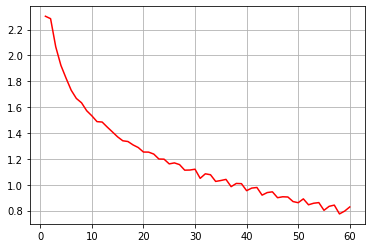

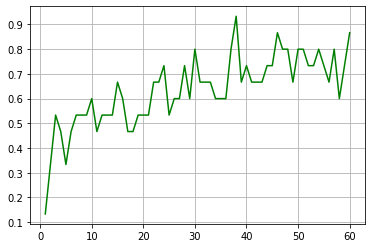

In [11]:
plt.plot(list(range(1, len(losses) + 1)), losses, color="red")
plt.grid()
plt.show()

plt.plot(list(range(1, len(accuracy) + 1)), accuracy, color="green")
plt.grid()
plt.show()